In [1]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import nltk
from nltk.corpus import stopwords

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [3]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

utd_tmp_wav_path = config['es']['utd_wavs']

In [4]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [5]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(mt_gold_eval_dict_fname):
    mt_gold_eval_dict = pickle.load(open(mt_gold_eval_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_eval_dict_fname):
    mt_pseudo_eval_dict = pickle.load(open(mt_pseudo_eval_dict_fname, "rb"))    

In [6]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    #if os.path.exists(nid_fname):
    #    return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [7]:
display(gen_node_wav(1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [8]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=True)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    #print(display_pp.get_html_string())

    

In [9]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+----------------+----------------------------------------------------+
| pair id |  nid  | ES transcript  |                   EN translation                   |
+---------+-------+----------------+----------------------------------------------------+
|  16210  | 14185 |  CUIDADO PERO  |  NO NO IT IS NO SO SERIOUS BUT SHE HAS THAT THAT   |
|         |       |                | WORRY WHO KNOWS MAYBE IS JUST MASS SOMETHING IS A  |
|         |       |                |                  LITTLE BALL THAT                  |
+---------+-------+----------------+----------------------------------------------------+
|  16210  | 14186 | LLAMAROS Y QUE | WELL SHE SAID THAT SHE SHE WAS GOING TO CALL SO I  |
|         |       |                | SHE HAD LEFT PHONE NUMBER BECAUSE SHE WAS SLEEPING |
|         |       |                | IT NOW TWO TIMES THAT HAS CALLED AND SHE 'S ASLEEP |
|         |       |                |                SO SHE CAN 'T ANSWER                |
+---------

## Pseudotext analysis

In [10]:
train_segment_list_fname, dev_segment_list_fname

(u'../files-train-segments-sf-10.txt', u'../files-dev-segments-sf-10.txt')

In [11]:
train_fids = []
train_sids = []
with open(train_segment_list_fname, "r") as in_f:
    for line in in_f:
        train_fids.append(line.strip().split(".")[0])
        train_sids.append(line.strip())
train_fids = set(train_fids)
train_sids = set(train_sids)

In [12]:
dev_fids = []
dev_sids = []
with open(dev_segment_list_fname, "r") as in_f:
    for line in in_f:
        dev_fids.append(line.strip().split(".")[0])
        dev_sids.append(line.strip())
dev_fids = set(dev_fids)
dev_sids = set(dev_sids)

In [13]:
clusters_stats['is_dev'] = []
clusters_stats['is_train'] = []
clusters_stats['oov'] = []
clusters_stats['cross_seg'] = []
clusters_stats['cross_file'] = []
clusters_stats['same_seg'] = []
clusters_stats['in_vocab'] = []
for sids in clusters_stats['sids']:
    is_in_dev = len(dev_sids & set(sids)) > 0
    is_in_train = len(train_sids & set(sids)) > 0
    clusters_stats['is_dev'].append(is_in_dev)
    clusters_stats['is_train'].append(is_in_train)
    clusters_stats['oov'].append(is_in_dev and not is_in_train)
    clusters_stats['in_vocab'].append(is_in_dev and is_in_train)
    cross_seg = False
    cross_file = False
    same_seg = False
    if is_in_dev and is_in_train:
        common_sids = (dev_sids & set(sids)) | (train_sids & set(sids))
        cross_seg = (len(common_sids) > 1)
        cross_file = (len(set([s.split('.')[0] for s in common_sids])) > 1)
        
    if is_in_dev or is_in_train:
        same_seg = (len(set(sids)) == 1)
        
    clusters_stats['cross_seg'].append(cross_seg)
    clusters_stats['cross_file'].append(cross_file)
    clusters_stats['same_seg'].append(same_seg)
        
        

clusters_stats['dev_depth'] = []
clusters_stats['train_depth'] = []
for nlist in clusters_stats['sids']:
    clusters_stats['dev_depth'].append(len([i for i in nlist if i in dev_sids]))
    clusters_stats['train_depth'].append(len([i for i in nlist if i in train_sids]))


In [14]:
num_oov = sum([i for i in clusters_stats['oov']])
print(num_oov)
sum_oov = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['oov'][i]])
total_pwords = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['is_dev'][i]])
print(sum_oov)
print(total_pwords)

583
627
1329


In [15]:
def mini_print(out_cols, out_rows):
    out_line = PrettyTable(out_cols)
    print(" & ".join(out_cols))
    if len(out_rows) > 1 and type(out_rows[0]) == list:
        for row in out_rows:
            out_line.add_row(row)
            print(" & ".join(map(str, row)))
    else:
        out_line.add_row(out_rows)
        print(" & ".join(map(str, out_rows)))
    print(out_line)

In [16]:
def oov_summary(dev_sids, feats_dict):
    dev_words = []
    train_words = []
    oov_pwords = []
    for did in dev_sids:
        dev_words.extend([w.decode('utf-8') for w in feats_dict[did]])
    for tid in train_sids:
        train_words.extend([w.decode('utf-8') for w in feats_dict[tid]])
    set_train_words = set(train_words)
    oov_words = [cid for cid in dev_words if cid not in set_train_words and cid != "-1"]
    missing_train_words = [cid for cid in train_words if cid == "-1"]
    missing_words = [cid for cid in dev_words if cid == "-1"]
    out_cols = ["train words", "dev words", "oov", "oov types", "miss.", "oov + miss.", "vocab", "oov vocab"]
    out_rows = [len(train_words), len(dev_words), len(oov_words), len(set(oov_words)), \
                len(missing_words), len(oov_words) + len(missing_words), len(set(dev_words)), len(set(oov_words))]
    mini_print(out_cols, out_rows)
    return Counter(train_words), Counter(dev_words), Counter(oov_words)

In [17]:
train_pwords, dev_pwords, oov_pwords = oov_summary(dev_sids, feats_dict)
train_gold_words, dev_gold_words, oov_gold_words = oov_summary(dev_sids, gold_feats_dict)

train words & dev words & oov & oov types & miss. & oov + miss. & vocab & oov vocab
15165 & 1660 & 627 & 583 & 331 & 958 & 1218 & 583
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
| train words | dev words | oov | oov types | miss. | oov + miss. | vocab | oov vocab |
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
|    15165    |    1660   | 627 |    583    |  331  |     958     |  1218 |    583    |
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
train words & dev words & oov & oov types & miss. & oov + miss. & vocab & oov vocab
27597 & 2862 & 291 & 272 & 0 & 291 & 1287 & 272
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
| train words | dev words | oov | oov types | miss. | oov + miss. | vocab | oov vocab |
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
|    27597    |    2862   | 29

In [18]:
train_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in train_pwords if cid != -1])
dev_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in dev_pwords if cid != -1])
oov_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in oov_pwords if cid != -1])

In [19]:
out_cols = ["train/dev/oov", "total", "types"]
out_rows = []
out_rows.append(['train', sum(train_pwords_es.values()), len(train_pwords_es)])
out_rows.append(['dev', sum(dev_pwords_es.values()), len(dev_pwords_es)])
out_rows.append(['oov', sum(oov_pwords_es.values()), len(oov_pwords_es)])
mini_print(out_cols, out_rows)

train/dev/oov & total & types
train & 8062 & 2352
dev & 1218 & 650
oov & 583 & 376
+---------------+-------+-------+
| train/dev/oov | total | types |
+---------------+-------+-------+
|     train     |  8062 |  2352 |
|      dev      |  1218 |  650  |
|      oov      |  583  |  376  |
+---------------+-------+-------+


In [20]:
inv_words = [cid for cid in set(dev_pwords) - set(oov_pwords)]
print("dev pwords in train vocab: %d" % len(inv_words))
missing_translations = [cid for cid in inv_words if cid not in pseudo_probs_dict]
print("translations missing for: %d" %len(missing_translations))

dev pwords in train vocab: 635
translations missing for: 1


In [21]:
def recall_summary(eval_dict, dev_sids, feats_dict, oov_words, k):
    k = 10
    num_en_oov = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_inv_and_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) > 0])
    num_only_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_en = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids)])
    num_en_missing = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if feats_dict[sid] == ['-1']])

    num_en_pred = sum([eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)])
    num_en_corr_pred = sum([eval_dict['dev'][k][sid]['cp'] for sid in set(dev_sids)])

    out_cols = ["total en", "en oov", "en missing", "upper bound recall"]
    out_rows = [num_en, num_en_oov, num_en_missing, "{0:.3f}".format((num_en-num_en_oov-num_en_missing)/num_en)]

    mini_print(out_cols, out_rows)

    out_cols = ["k", "\\# corr.", "\\# pred", "prec.", "rec.", "rec. w/o miss.", "rec. w/o oov", "rec. w/o miss.+oov"]
    out_rows = map(lambda v: "{0:.2f} \%".format(v*100) if type(v) != int else v, \
                   [k, num_en_corr_pred, num_en_pred, (num_en_corr_pred/num_en_pred), (num_en_corr_pred/num_en), num_en_corr_pred/(num_en-num_en_missing), \
                    num_en_corr_pred/(num_en-num_en_oov), num_en_corr_pred/(num_en-num_en_missing-num_en_oov)])
    mini_print(out_cols, out_rows)
    mini_print(['inv+oov', 'only oov'], [num_inv_and_oov, num_only_oov])

In [22]:
k=10
recall_summary(mt_pseudo_eval_dict, dev_sids, feats_dict, oov_pwords, k)

total en & en oov & en missing & upper bound recall
2899 & 271 & 862 & 0.609
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   2899   |  271   |    862     |       0.609        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
10 & 210 & 3982 & 5.27 \% & 7.24 \% & 10.31 \% & 7.99 \% & 11.89 \%
+----+----------+---------+---------+---------+----------------+--------------+--------------------+
| k  | \# corr. | \# pred |  prec.  |   rec.  | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+----+----------+---------+---------+---------+----------------+--------------+--------------------+
| 10 |   210    |   3982  | 5.27 \% | 7.24 \% |    10.31 \%    |   7.99 \%    |      11.89 \%      |
+----+----------+---------+---------+---------+----------------+--------------+-

In [23]:
recall_summary(mt_gold_eval_dict, dev_sids, gold_feats_dict, oov_gold_words, k)
'''
The impact of oov words is less in the case of gold features, 
as other words in the utterances still make predictions. 

However, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when
oov words are encountered
'''

total en & en oov & en missing & upper bound recall
2899 & 21 & 0 & 0.993
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   2899   |   21   |     0      |       0.993        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
10 & 1698 & 8654 & 19.62 \% & 58.57 \% & 58.57 \% & 59.00 \% & 59.00 \%
+----+----------+---------+----------+----------+----------------+--------------+--------------------+
| k  | \# corr. | \# pred |  prec.   |   rec.   | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+----+----------+---------+----------+----------+----------------+--------------+--------------------+
| 10 |   1698   |   8654  | 19.62 \% | 58.57 \% |    58.57 \%    |   59.00 \%   |      59.00 \%      |
+----+----------+---------+----------+----------+----------------+-----

'\nThe impact of oov words is less in the case of gold features, \nas other words in the utterances still make predictions. \n\nHowever, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when\noov words are encountered\n'

In [24]:
mini_print(["train fids", "dev fids", "train sids", "dev sids"], \
          [len(train_fids), len(dev_fids), len(train_sids), len(dev_sids)])

train fids & dev fids & train sids & dev sids
36 & 36 & 5930 & 639
+------------+----------+------------+----------+
| train fids | dev fids | train sids | dev sids |
+------------+----------+------------+----------+
|     36     |    36    |    5930    |   639    |
+------------+----------+------------+----------+


In [25]:
def show_common(counter_A, counter_B):
    set_A = set(counter_A.keys())
    set_B = set(counter_B.keys())
    common = set_A & set_B
    return common, len(common)

In [26]:
_, k = show_common(oov_pwords_es, oov_gold_words)
print(k)
_, k = show_common(train_pwords_es, train_gold_words)
print(k, len(train_pwords_es), len(train_gold_words))

21
1538 2352 5389


In [27]:
def get_dur_for_sids(sids, align_dict):
    dur = 0
    for sid in sids:
        dur += sum([word.end-word.start for word in align_dict[sid.split('.')[0]][sid]['es']])
    return dur / (100 * 3600)

In [28]:
# train sids duration
train_sid_dur = "%.3f" % get_dur_for_sids(train_sids, align_dict)
dev_sid_dur = "%.3f" % get_dur_for_sids(dev_sids, align_dict)
mini_print(["train sid dur", "dev sid dur"], [train_sid_dur, dev_sid_dur])

train sid dur & dev sid dur
4.418 & 0.450
+---------------+-------------+
| train sid dur | dev sid dur |
+---------------+-------------+
|     4.418     |    0.450    |
+---------------+-------------+


### pseudowords

## Cluster Analysis

In [29]:
def plot_word_freq(count_dict, num=10, fig_name = '', prefix='', color='salmon'):
    if prefix:
        count_dict = {"%s_%s" % (prefix, k): v for k,v in count_dict.items()}
    pd_es_df = pd.DataFrame(sorted(count_dict.items(), reverse=True, key=lambda t:t[1])[:num], index=range(num))
    pd_es_df.columns = ["word", "freq"]
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(y='word', x="freq", data=pd_es_df, label=fig_name, color=color)
    ax.legend(ncol=1, loc="center right", frameon=True, fontsize=20)

    #ax.set(xlim=(0, 300))

    plt.xlabel("word counts", size=20)
    plt.ylabel("word types", size=20)

    plt.yticks(rotation=0, size=18)
    plt.xticks(rotation=0, size=18)

    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    

In [30]:
def get_en_words(align_dict, seg_id, en_key):
    en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key] if "'" not in w.word]
    if not en_words:
        en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en'] if "'" not in w.word]
    return en_words

In [31]:
def get_word_counts(w_key, feats_dict, align_dict, sids):
    if w_key.startswith('es'):
        wrds = [a.decode("utf-8") for sid in feats_dict for a in feats_dict[sid] if sid in sids]
    else:
        wrds = [a for sid in sids for a in get_en_words(align_dict, sid, w_key)]
    return Counter(wrds)

In [32]:
def calc_avg_purity(clusters_df):
    num = sum(clusters_df.apply(lambda row: \
                            Counter(row.words).most_common(1)[0][1] \
                            if len(row.words) > 0 else 0, axis=1))
    den = sum(clusters_df.apply(lambda row: len(row.words), axis=1))
    return (num / den)

In [33]:
def play_cluster(cid):
    cid_wav_path = os.path.join(config["es"]["zrt_tmp_wav"], "%04d.wav" %(cid+1))
    return Audio(cid_wav_path)

In [34]:
temp_train_pwords = {k:v for k, v in train_pwords.items()}
del temp_train_pwords['-1']
temp_train_pwords.items()[:5]

[(u'11542', 3), (u'11543', 2), (u'11540', 2), (u'11541', 1), (u'11546', 2)]

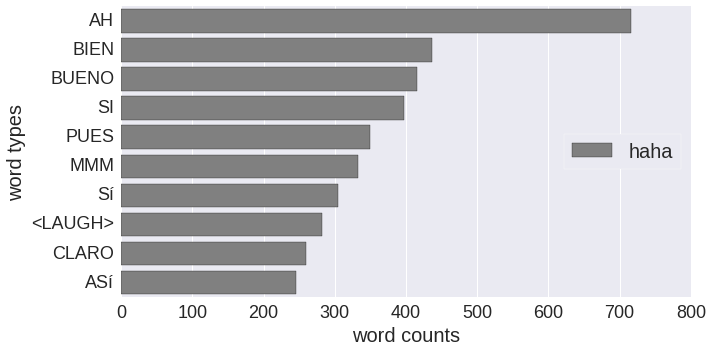

In [35]:
plot_word_freq(train_gold_words, fig_name="haha", color='grey')

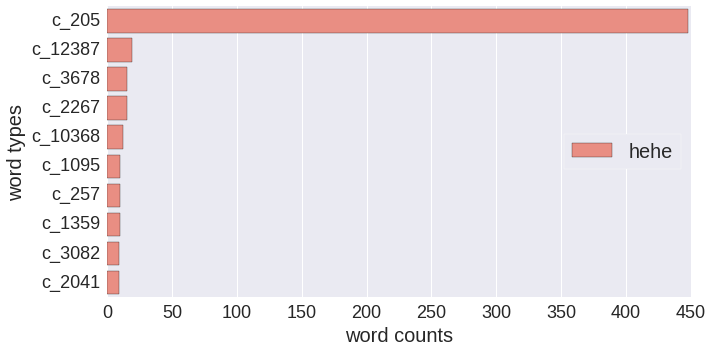

In [36]:
plot_word_freq(temp_train_pwords, fig_name="hehe", prefix='c', color="salmon")

In [37]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [38]:
print(len(clusters_df[clusters_df['same_seg']== True]), len(clusters_df))

197 15089


In [39]:
print(len(clusters_df[clusters_df['cross_seg']== True]), len(clusters_df))

634 15089


In [40]:
print(len(clusters_df[clusters_df['cross_file']== True]), len(clusters_df))

414 15089


In [99]:
cross_seg_cids = {s for s, c in enumerate(clusters_stats['cross_seg']) if c == True}

In [42]:
cross_file_cids = {s for s, c in enumerate(clusters_stats['cross_file']) if c == True}

In [101]:
print(len(set(train_pwords) & set(dev_pwords)))
hmm = {int(i) for i in set(train_pwords) & set(dev_pwords)}

635


### View clusters

In [49]:
view_cols = ['most_common', 'oov', 'purity', 'words', 'depth', 'cross_seg', 'cross_file']

In [50]:
(clusters_df[view_cols].sort_values('depth', ascending=False, inplace=False)).head(5)

,most_common,oov,purity,words,depth,cross_seg,cross_file
205,así,False,0.035620,"[llamó, miguel, temprano, entonces, contenta, ...",2274,True,True
2041,cualquier,False,0.048387,"[principios, difícil, ataque, ataque, tarjetas...",62,True,True
470,tanta,False,0.054545,"[totalmente, trucho, cuestan, disparate, toman...",55,False,False
3678,cómo,False,0.090909,"[papá, entonces, pones, sabo, cómo, súper, con...",44,True,True
905,regalitos,False,0.047619,"[empezaste, voy, empezar, diciendo, sumamente,...",42,False,False


In [51]:
clusters_df[view_cols][(clusters_df.depth >= 10) & (clusters_df.purity >= 0.7)].head(10)

,most_common,oov,purity,words,depth,cross_seg,cross_file
342,claro,False,1.000000,"[claro, claro, claro, claro, claro, claro, cla...",11,True,True
4167,claro,False,1.000000,"[claro, claro, claro, claro, claro, claro, cla...",16,False,False
4217,<laugh>,False,0.951220,"[importante, <laugh>, <laugh>, <laugh>, <laugh...",41,False,False
8995,okey,False,0.833333,"[okey, okey, okey, pueda, okey, okey, okey, ok...",18,False,False
10368,mmm,False,1.000000,"[mmm, mmm, mmm, mmm, mmm, mmm, mmm, mmm, mmm, ...",12,False,False
12387,entiendes,False,0.740741,"[entiendes, entiendes, entiendes, tiempo, enti...",27,True,False


In [52]:
display(play_cluster(205))
display(clusters_df.ix[205])

cross_file                                                  True
cross_seg                                                   True
dev_depth                                                     42
fids           [002, 015, 002, 031, 002, 037, 002, 039, 002, ...
in_vocab                                                    True
is_dev                                                      True
is_train                                                    True
most_common                                                  así
oov                                                        False
purity                                                 0.0356201
same_seg                                                   False
sids           [002.047, 015.004, 002.122, 031.076, 002.084, ...
train_depth                                                  448
words          [llamó, miguel, temprano, entonces, contenta, ...
depth                                                       2274
Name: 205, dtype: object

In [53]:
def sid_to_cid_mapping(clusters_stats):
    sid_to_cids = {}
    for cid, sids in enumerate(clusters_stats['sids']):
        for sid in sids:
            if sid not in sid_to_cids:
                sid_to_cids[sid] = set()
            sid_to_cids[sid] |= {cid}
    return sid_to_cids
            

In [54]:
sid_to_cids = sid_to_cid_mapping(clusters_stats)

In [55]:
def get_cids_for_sid(sid, clusters_stats):
    sid_cids = [cid for cid, sids in enumerate(clusters_stats["sids"]) if sid in sids]
    return sid_cids

In [56]:
def find_sids_with_common_pwords(clusters_stats, filter_sids, sid_to_cids):
    check_sids = list(filter_sids)
    sid_overlap = []
    for i in range(len(check_sids)):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(check_sids)) )
        for j in range(i+1, len(check_sids)):
            if check_sids[i] in sid_to_cids and check_sids[j] in sid_to_cids:
                t1 = sid_to_cids[check_sids[i]]
                t2 = sid_to_cids[check_sids[j]]
                if len(t1 & t2) > 0:
                    sid_overlap.append((check_sids[i], check_sids[j], len(t1 & t2), t1&t2))
    return sid_overlap

In [96]:
def find_cids_with_common_sids(clusters_stats, filter_sids):
    cid_overlap = []
    for i in range(len(clusters_stats['sids'])):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(clusters_stats['sids'])) )
        for j in range(i+1, len(clusters_stats['sids'])):
            t1 = set(clusters_stats['sids'][i]) & filter_sids
            t2 = set(clusters_stats['sids'][j]) & filter_sids
            if len(t1 & t2) > 0:
                cid_overlap.append((i, j, len(t1 & t2), t1&t2))
    return cid_overlap

In [58]:
sid_overlap = find_sids_with_common_pwords(clusters_stats, train_sids, sid_to_cids)

at 0 out of 5930 ... 
at 1000 out of 5930 ... 
at 2000 out of 5930 ... 
at 3000 out of 5930 ... 
at 4000 out of 5930 ... 
at 5000 out of 5930 ... 


In [59]:
display(sorted(sid_overlap, reverse=True, key=lambda t:t[2])[:10])

[('106.026', '106.025', 4, {10528, 10532, 10537, 10538}),
 ('111.029', '111.015', 4, {205, 4101, 11188, 11189}),
 ('090.028', '090.031', 4, {8195, 8199, 8201, 8204}),
 ('083.205', '110.166', 4, {205, 6971, 7102, 10895}),
 ('114.151', '114.142', 4, {205, 2267, 3837, 11845}),
 ('105.256', '105.266', 4, {10372, 10381, 10382, 10383}),
 ('116.012', '116.218', 3, {12031, 12076, 12111}),
 ('101.083', '101.065', 3, {1244, 9847, 9856}),
 ('111.144', '111.007', 3, {205, 3082, 5665}),
 ('111.144', '114.026', 3, {205, 11220, 11825})]

In [60]:
cid_overlap = find_cids_with_common_sids(clusters_stats, train_sids)

at 0 out of 15089 ... 
at 200 out of 15089 ... 
at 400 out of 15089 ... 
at 600 out of 15089 ... 
at 800 out of 15089 ... 
at 1000 out of 15089 ... 
at 1200 out of 15089 ... 
at 1400 out of 15089 ... 
at 1600 out of 15089 ... 
at 1800 out of 15089 ... 
at 2000 out of 15089 ... 
at 2200 out of 15089 ... 
at 2400 out of 15089 ... 
at 2600 out of 15089 ... 
at 2800 out of 15089 ... 
at 3000 out of 15089 ... 
at 3200 out of 15089 ... 
at 3400 out of 15089 ... 
at 3600 out of 15089 ... 
at 3800 out of 15089 ... 
at 4000 out of 15089 ... 
at 4200 out of 15089 ... 
at 4400 out of 15089 ... 
at 4600 out of 15089 ... 
at 4800 out of 15089 ... 
at 5000 out of 15089 ... 
at 5200 out of 15089 ... 
at 5400 out of 15089 ... 
at 5600 out of 15089 ... 
at 5800 out of 15089 ... 
at 6000 out of 15089 ... 
at 6200 out of 15089 ... 
at 6400 out of 15089 ... 
at 6600 out of 15089 ... 
at 6800 out of 15089 ... 
at 7000 out of 15089 ... 
at 7200 out of 15089 ... 
at 7400 out of 15089 ... 
at 7600 out of 1508

In [139]:
purity_cid_overlap = [cid for cid in cid_overlap if \
                      clusters_stats['purity'][cid[0]] >= 0.5 or \
                      clusters_stats['purity'][cid[1]] >= 0.5]

In [141]:
display(sorted(cid_overlap, reverse=True, key=lambda t:t[2])[270:450])

[(205, 12649, 2, {'120.139', '120.179'}),
 (257, 7961, 2, {'088.032', '088.179'}),
 (275, 4077, 2, {'091.107', '100.129'}),
 (275, 8283, 2, {'091.044', '091.107'}),
 (275, 11800, 2, {'091.044', '114.134'}),
 (413, 11851, 2, {'114.007', '114.013'}),
 (470, 1000, 2, {'111.007', '111.104'}),
 (470, 3082, 2, {'111.007', '112.012'}),
 (470, 9687, 2, {'100.003', '100.109'}),
 (759, 8545, 2, {'092.047', '092.094'}),
 (773, 9705, 2, {'100.039', '100.051'}),
 (786, 9937, 2, {'103.054', '103.068'}),
 (786, 10028, 2, {'103.054', '103.068'}),
 (1216, 7231, 2, {'084.158', '084.160'}),
 (1244, 9847, 2, {'101.065', '101.083'}),
 (1244, 9856, 2, {'101.065', '101.083'}),
 (1265, 8144, 2, {'090.028', '116.075'}),
 (1265, 12080, 2, {'116.075', '116.102'}),
 (1266, 12165, 2, {'117.042', '117.044'}),
 (1359, 7648, 2, {'087.026', '087.217'}),
 (1434, 7386, 2, {'085.073', '085.118'}),
 (1447, 8369, 2, {'091.200', '091.202'}),
 (1627, 11542, 2, {'104.016', '114.123'}),
 (1739, 7098, 2, {'083.137', '110.009'})

In [63]:
display(clusters_df[view_cols].ix[[275, 8283, 11800]])
display(clusters_df[view_cols].ix[[205, 6971, 7102, 10895]])

,most_common,oov,purity,words,depth,cross_seg,cross_file
275,trabajo,False,0.176471,"[siete, días, haití, cómo, gracias, besote, tr...",17,False,False
8283,trabajo,False,0.666667,"[trabajo, mejor, trabajo, trabajo, trabajo, papá]",6,False,False
11800,tal,False,0.333333,"[tal, vas, trabajo]",3,False,False


,most_common,oov,purity,words,depth,cross_seg,cross_file
205,así,False,0.035620,"[llamó, miguel, temprano, entonces, contenta, ...",2274,True,True
6971,pañal,False,0.200000,"[tocaya, fabiola, interesante, cambié, pañal]",5,False,False
7102,pañal,False,0.333333,"[fabiola, cambié, pañal]",3,False,False
10895,pañal,False,0.333333,"[cambié, pañal, fabiola]",3,False,False


In [64]:
clusters_df.ix[[10528, 10532, 10537, 10538]]

,cross_file,cross_seg,dev_depth,fids,in_vocab,is_dev,is_train,most_common,oov,purity,same_seg,sids,train_depth,words,depth
10528,False,False,0,"[106, 106]",False,False,True,alemán,False,1.000000,False,"[106.025, 106.026]",2,"[alemán, alemán]",2
10532,False,False,0,"[106, 106]",False,False,True,alemán,False,0.333333,False,"[106.025, 106.026]",2,"[alemania, alemán, después]",3
10537,False,False,0,"[106, 106]",False,False,True,alemán,False,0.500000,False,"[106.025, 106.026]",2,"[castellano, alemán, castellano, alemán]",4
10538,False,False,0,"[106, 106]",False,False,True,alemán,False,0.666667,False,"[106.025, 106.026]",2,"[alemán, castellano, alemán]",3


In [126]:
clusters_df.ix[4077]

cross_file                                         True
cross_seg                                          True
dev_depth                                             1
fids                               [061, 100, 088, 091]
in_vocab                                           True
is_dev                                             True
is_train                                           True
most_common                                       forma
oov                                               False
purity                                         0.166667
same_seg                                          False
sids               [061.142, 100.129, 088.027, 091.107]
train_depth                                           2
words          [fin, semana, forma, temporal, sale, co]
depth                                                 6
Name: 4077, dtype: object

In [129]:
map(lambda t: (t, nodes_dict[t]), clusters[4077])

[(10679,
  Node(file='061', seg='061.142', start=429, end=480, es=('FIN', 'DE', 'SEMANA'), es_cnt=('FIN', 'SEMANA'))),
 (10680,
  Node(file='100', seg='100.129', start=10, end=62, es=('S\xc3\xad', 'YO', 'ESTOY', 'CON'), es_cnt=())),
 (23911,
  Node(file='088', seg='088.027', start=186, end=239, es=('FORMA', 'TEMPORAL'), es_cnt=('FORMA', 'TEMPORAL'))),
 (25197,
  Node(file='091', seg='091.107', start=138, end=194, es=('SALE', 'ESTA', 'CO'), es_cnt=('SALE', 'CO')))]

In [121]:
clusters_stats['most_common'][11800]

u'tal'

In [128]:
feats_dict['091.107'], feats_dict['100.129']

(['205',
  '205',
  '275',
  '2430',
  '4077',
  '5635',
  '7082',
  '8283',
  '8343',
  '8405',
  '8465',
  '11803',
  '13969'],
 ['205', '275', '781', '3678', '4077', '5640', '8033', '9640', '9650', '9730'])

In [116]:
nodes_dict[38714], nodes_dict[24855], nodes_dict[38713], nodes_dict[25249]

(Node(file='091', seg='091.044', start=122, end=177, es=('DEL', 'TRABAJO', 'MI'), es_cnt=('TRABAJO',)),
 Node(file='091', seg='091.107', start=235, end=291, es=('ESTE', 'TRABAJO', 'Y', 'SE'), es_cnt=('TRABAJO',)),
 Node(file='114', seg='114.134', start=241, end=298, es=('QU\xc3\xa9', 'TAL', 'VAS', 'CON', 'LA'), es_cnt=('TAL', 'VAS')),
 Node(file='091', seg='091.041', start=493, end=552, es=('TRABAJO', 'EN', 'TRABAJO'), es_cnt=('TRABAJO', 'TRABAJO')))

In [117]:
display(clusters[11800])
display(gen_node_wav(24855, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
print(' '.join(nodes_dict[24855].es))

display(gen_node_wav(38713, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
print(' '.join(nodes_dict[38713].es))
display(gen_node_wav(38714, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
print(' '.join(nodes_dict[38714].es))
display(gen_node_wav(25249, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
print(' '.join(nodes_dict[25249].es))

[38713, 38714]

ESTE TRABAJO Y SE


QUé TAL VAS CON LA


DEL TRABAJO MI


TRABAJO EN TRABAJO


In [147]:
# 2267, 3682, 2, {'114.134', '114.142'}
display(len(clusters[2267]))

for nid in clusters[2267]:
    if nodes_dict[nid].seg in {'114.134', '114.142'}:
        display(gen_node_wav(nid, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
        print(' '.join(nodes_dict[nid].es))

23

Sí PUES Y


Sí PUES VAYA


In [107]:
clusters_df[view_cols+['sids', 'in_vocab']][(clusters_df.depth >=4) & (clusters_df.purity >= .6) \
                               & (clusters_df.purity <= 0.9) & (clusters_df.is_train == True) & \
                                           (clusters_df.in_vocab == True)]

,most_common,oov,purity,words,depth,cross_seg,cross_file,sids,in_vocab
394,pues,False,0.714286,"[pues, pues, pues, pues, pues, bebido, parece]",7,True,False,"[002.029, 114.130, 114.181, 114.026, 114.142, ...",True
1244,completo,False,0.600000,"[concreto, completo, completo, completo, compl...",5,True,False,"[009.179, 101.083, 101.065, 101.046, 101.091]",True
2020,entonces,False,0.625000,"[entonces, entonces, tomé, después, entonces, ...",8,True,True,"[050.121, 030.007, 105.005, 120.043, 111.173, ...",True
2758,así,False,0.750000,"[boston, así, así, así]",4,True,True,"[054.268, 111.108, 114.013, 087.213, 088.157, ...",True
7928,parece,False,0.750000,"[parece, parece, parece, ser]",4,True,False,"[088.165, 088.168, 088.172]",True
8801,ojalá,False,0.750000,"[ah, ojalá, ojalá, ojalá]",4,True,False,"[095.055, 095.064]",True
8808,carrera,False,0.600000,"[estudian, carrera, carrera, entras, carrera]",5,True,False,"[095.149, 095.166, 095.058]",True
10394,fotos,False,0.600000,"[unas, fotos, unas, fotos, fotos]",5,True,False,"[105.003, 105.017, 105.073]",True
11577,chi,False,0.666667,"[tai, chi, chi, tai, chi, chi]",6,True,False,"[113.197, 113.209]",True
12387,entiendes,False,0.740741,"[entiendes, entiendes, entiendes, tiempo, enti...",27,True,False,"[119.025, 119.029, 119.075, 119.079, 119.112, ...",True


In [67]:
sid = '083.205'
display(clusters_df[view_cols].ix[list(sid_to_cids[sid])])
# display(clusters_df.sids[list(sid_to_cids[sid])])
print(' '.join([a.word.lower() for a in align_dict[sid.split('.')[0]][sid]['es']]))

,most_common,oov,purity,words,depth,cross_seg,cross_file
6945,vereda,False,1.000000,[vereda],1,False,False
6948,carta,False,0.500000,"[carta, ligia]",2,False,False
7525,va,False,0.125000,"[papá, menos, va, matar, van, acá, aplazó, fab...",8,False,False
6982,aquí,False,0.250000,"[colombia, tocaya, aquí, ahora]",4,False,False
13964,consigo,False,0.250000,"[igual, consigo, tocaya, fabiola]",4,False,False
205,así,False,0.035620,"[llamó, miguel, temprano, entonces, contenta, ...",2274,True,True
3981,mota,False,0.333333,"[mugre, fabiola, mota]",3,False,False
6963,septiembre,False,0.333333,"[tocaya, veintitrés, septiembre]",3,False,False
6969,tocaya,False,0.250000,"[tocaya, fabiola, ir, javier]",4,False,False
6971,pañal,False,0.200000,"[tocaya, fabiola, interesante, cambié, pañal]",5,False,False


sí mira bueno esta es la de colombia y era mi tocaya también fabiola se llamaba fabiola mota


In [68]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(5)

,n1,n2,dtw,es_sim,es_cnt_sim,en_j_sim
4361,13465,13466,0.999,1,1,1.000000
2869,18715,18716,0.999,1,1,0.250000
12798,12919,12920,0.999,1,1,0.222222
4709,55845,55846,0.999,1,1,0.200000
9457,9885,9886,0.999,1,1,0.142857


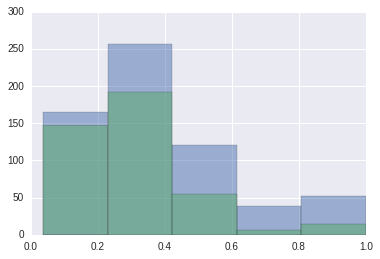

In [69]:
# clusters_df['purity'].hist()
clusters_df.purity[clusters_df.cross_seg == True].hist(alpha=0.5, bins=5)
clusters_df.purity[clusters_df.cross_file == True].hist(alpha=0.5, bins=5)

In [70]:
calc_avg_purity(clusters_df)

0.339489235964542

In [71]:
calc_avg_purity(clusters_df[clusters_df.same_seg])

0.58412698412698416

In [72]:
len(clusters_df[(clusters_df.cross_seg ==  True) & (clusters_df.cross_file == True)])

414

In [73]:
calc_avg_purity(clusters_df[clusters_df.cross_seg & (clusters_df.cross_file == False)])

0.45785876993166286

In [74]:
calc_avg_purity(clusters_df[clusters_df.cross_file])

0.13476230899830222

In [75]:
calc_avg_purity(clusters_df[clusters_df.is_dev]), calc_avg_purity(clusters_df[clusters_df.is_train])

(0.22306684141546526, 0.30580337162464566)

In [76]:
len(clusters_df[clusters_df.cross_file]), len(clusters_df)

(414, 15089)

In [77]:
len(clusters_df[clusters_df.is_dev])

1217

In [78]:
len(clusters_df[(clusters_df.is_dev == True) & (clusters_df.is_train == False)])

583

In [79]:
# !ls ../../../ZRTools/exp/callhome/tmpwav/

In [80]:
k = 1
uttr = "010.169"
# uttr = "011.178"
# uttr = "002.008"

In [81]:
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['es']]))
print(" ".join([w.word.decode("utf-8") for w in align_dict[uttr.split(".")[0]][uttr]['en_cnt']]))

AH BUENO ESA ES LA CUESTIóN OYE BUENO Y
OH WELL 'S PROBLEM HEY WELL


In [82]:
print(" ".join([w.decode("utf-8") for w in gold_feats_dict[uttr]])),
print(" ".join([w.decode("utf-8") for w in feats_dict[uttr]]))

AH BUENO CUESTIóN OYE BUENO
1303


In [83]:
# pseudo_probs_dict['1354']

In [84]:
print(" ".join([w.decode("utf-8") for w in mt_gold_pred_dict[k][uttr]])),
print(" ".join([w.decode("utf-8") for w in mt_pseudo_pred_dict[k][uttr]]))

YES WELL QUESTION HEY WELL



In [85]:
[(key, v['t']) for key,v in mt_pseudo_eval_dict['dev'][k].items() if type(v) == dict and v['cp'] == 1]

[('087.035', 6),
 ('108.158', 13),
 ('092.127', 4),
 ('083.185', 1),
 ('085.136', 6),
 ('096.104', 17),
 ('119.015', 17),
 ('104.022', 5),
 ('095.195', 11),
 ('085.126', 4),
 ('112.054', 5),
 ('117.106', 5),
 ('086.244', 5),
 ('106.184', 11),
 ('105.037', 3),
 ('088.165', 11),
 ('113.114', 1),
 ('085.038', 4),
 ('093.330', 3),
 ('114.130', 3),
 ('091.225', 9),
 ('103.002', 6),
 ('105.137', 4),
 ('111.110', 2),
 ('119.025', 16),
 ('114.009', 8),
 ('095.055', 7),
 ('111.167', 27),
 ('081.259', 40),
 ('115.170', 15),
 ('095.084', 6),
 ('106.113', 6),
 ('105.127', 1)]

## Calculate duration in dev, test, and training sets

In [86]:
merged_fa_vads_path = config['es']['es_merge_fa_vad']

In [87]:
dur = {"tot":{}, "ge500ms":{}}

In [88]:
vad_flist = [os.path.join(merged_fa_vads_path, fil) for fil in os.listdir(merged_fa_vads_path) if fil.endswith(".vad")]

In [89]:
for vad_fname in vad_flist:
    with open(vad_fname, "r") as in_f:
        dur_key = int(os.path.splitext(os.path.basename(vad_fname))[0])
        dur["tot"][dur_key] = 0
        dur["ge500ms"][dur_key] = 0
        for line in in_f:
            start, end = map(int, line.strip().split())
            dur_ms = ((end-start) * 10)
            dur["tot"][dur_key] += dur_ms
            dur["ge500ms"][dur_key] += (dur_ms if dur_ms >= 500 else 0)
print("Completed calculating durations")

Completed calculating durations


In [90]:
def check_dur(dur_list, startid, endid):
    filtered_dur = [(f,d) for f, d in dur_list if f >= startid and f <= endid]
    dur = sum([d for f, d in filtered_dur])
    return filtered_dur, dur/(1000 * 3600)

In [91]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 41, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 41, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 9.565(hrs), dur >= 500ms: 8.527(hrs)
71 71


In [92]:
# dev set duration
dev_dur_list, d_dur = check_dur(dur["tot"].items(), 1, 20)
dev_dur_500ms_list, d_dur_500ms = check_dur(dur["ge500ms"].items(), 1, 20)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(d_dur, d_dur_500ms))
d_files = sum([1 for f, d in dev_dur_500ms_list if d > 0])
print(d_files, len(dev_dur_500ms_list))

total dur: 1.788(hrs), dur >= 500ms: 1.584(hrs)
13 13


In [93]:
# test set duration
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["tot"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["ge500ms"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))

test_dur_list, t_dur = check_dur(dur["tot"].items(), 21, 40)
test_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 21, 40)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in test_dur_500ms_list if d > 0])
print(t_files, len(test_dur_500ms_list))

total dur (hrs) 1.351
total dur (hrs) 1.218
total dur: 1.351(hrs), dur >= 500ms: 1.218(hrs)
20 20


In [94]:
# Train subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 85, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 85, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

# Dev subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 81, 84)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 81, 84)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 4.360(hrs), dur >= 500ms: 3.886(hrs)
32 32
total dur: 0.509(hrs), dur >= 500ms: 0.446(hrs)
4 4
